In [1]:
import sys
paths = ["../../ymbot/ymbot_utils"]
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
        
import open3d as o3d
import rosbag2_py
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
import numpy as np
from ymbot_utils import point_cloud2
import copy
import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from cv_bridge import CvBridge
from cv2 import aruco
import cv2
import time
import datetime
import json
from pathlib import Path

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def make_color_image_from_ros_message(message):
    bridge = CvBridge()
    return bridge.imgmsg_to_cv2(message)

def load_messages_from_rosbag(rosbag_path, topic_name, count=1, skip_rate=1):
    storage_options = rosbag2_py.StorageOptions(uri=rosbag_path, storage_id='sqlite3')
    converter_options = rosbag2_py.ConverterOptions(
        input_serialization_format='cdr',
        output_serialization_format='cdr')
    reader = rosbag2_py.SequentialReader()
    reader.open(storage_options, converter_options)
    topic_types = reader.get_all_topics_and_types()
    print([x.type for x in topic_types])
    print([x.name for x in topic_types])
    topic_type = [x.type for x in topic_types if x.name == topic_name][0]


    msgs = []
    i = 0
    j = 0
    while reader.has_next() and (((count is not None) and (i < count)) or (count is None)):
        (topic, data, t) = reader.read_next()
        if topic == topic_name:
            msg_type = get_message(topic_type)
            if j % skip_rate == 0:
                msg = deserialize_message(data, msg_type)
                msgs.append(msg)
                i += 1
            j += 1
    return msgs

def from_ros_timestamp(timestamp):
    return timestamp.sec + timestamp.nanosec * 1e-9

In [4]:
# ROSBAG_PATH = "/home/m-kurenkov/Downloads/floor3_query"
# ROSBAG_PATH = "/home/m-kurenkov/datasets/warehouse_tarnie_06_14/rosbag2_2022_06_14-21_21_18"
ROSBAG_PATH = "/home/m-kurenkov/datasets/warehouse_06_23/map_building/rosbag2_2022_06_23-21_01_40"
topic_name = "/color/image_raw"
topic_name = "/camera/color/image_raw"

['sensor_msgs/msg/Image', 'sensor_msgs/msg/PointCloud2']
['/camera/color/image_raw', '/hesai/pandar']


[INFO] [1656067358.535688312] [rosbag2_storage]: Opened database '/home/m-kurenkov/datasets/warehouse_06_23/map_building/rosbag2_2022_06_23-21_01_40/rosbag2_2022_06_23-21_01_40_0.db3' for READ_ONLY.


908


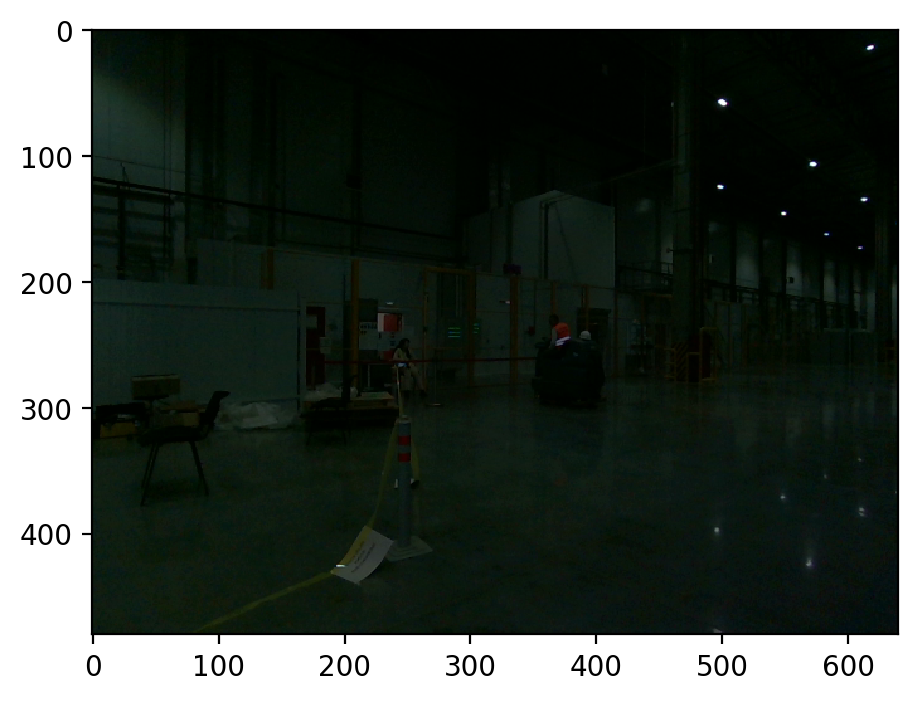

In [5]:
msgs = load_messages_from_rosbag(ROSBAG_PATH, topic_name, skip_rate=5, count=2000)
image_timestamps = [from_ros_timestamp(x.header.stamp) for x in msgs]
message = msgs[0]
IMAGES = [make_color_image_from_ros_message(x) for x in msgs]
plt.figure(dpi=200)
plt.imshow(IMAGES[0], cmap="gray")
print(len(IMAGES))

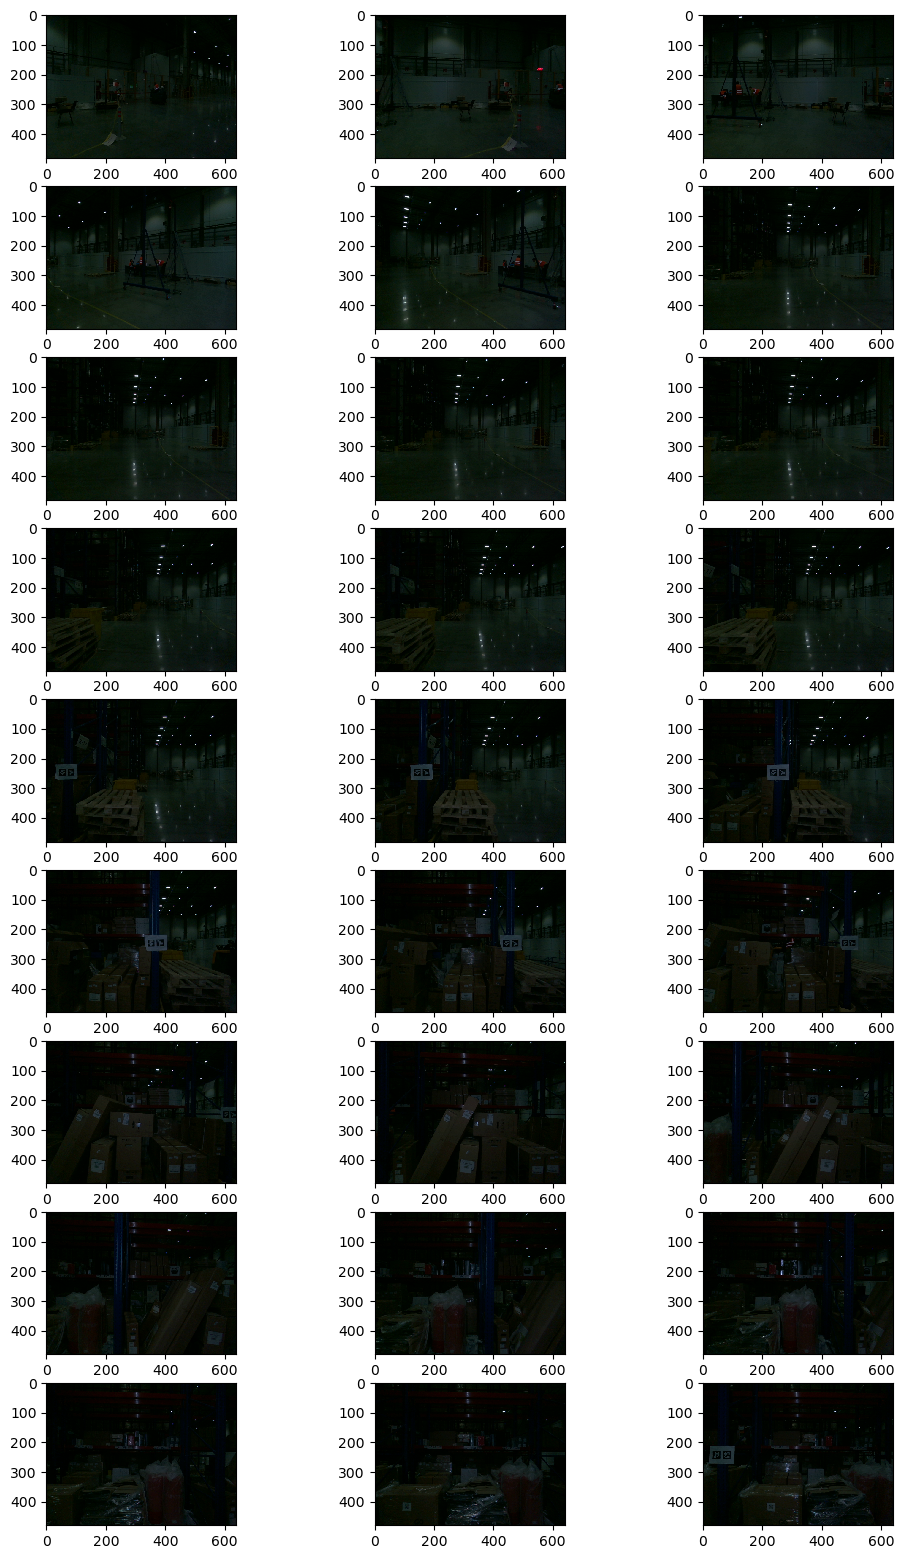

In [6]:
k = 3
count = 27
fix, ax = plt.subplots(count // k, k, dpi=100, figsize=(12, 20))
for i, image in enumerate(IMAGES[:count * 5:5]):
    ax[i // k][i % k].imshow(image)

# Detect aruco

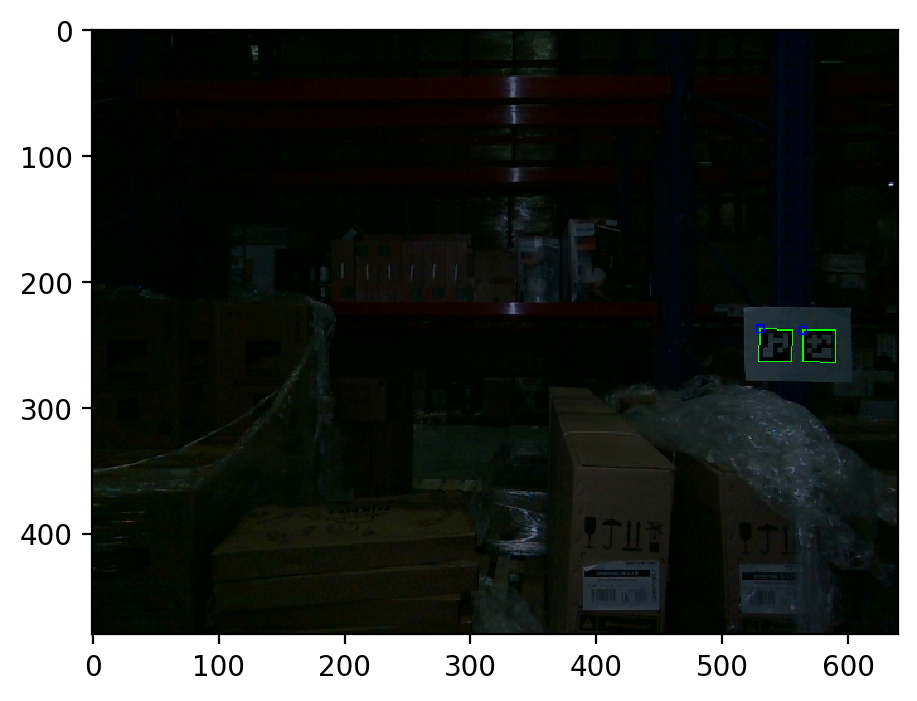

In [21]:
index = 150
image = IMAGES[index]
corners, ids, rejected_points = aruco.detectMarkers(image, aruco.Dictionary_get(aruco.DICT_5X5_1000))
detected_marker_image = aruco.drawDetectedMarkers(IMAGES[index].copy(), corners)
plt.figure(dpi=200)
plt.imshow(detected_marker_image)
# plt.xlim(200, 400)
# plt.ylim(200, 300)

In [20]:
def validate_detection(images, preprocess=None):
    detection_count = 0
    image_without_markers = 0
    times = []
    for i, image in enumerate(images):
        start_time = time.time()
        if preprocess is not None:
            image = preprocess(image)
        corners, ids, rejected_points = aruco.detectMarkers(image, aruco.Dictionary_get(aruco.DICT_5X5_1000))
        if ids is not None and 283 in ids:
            print(i)
        times.append(time.time() - start_time)
        detection_count += len(corners)
        if len(corners) == 0:
            image_without_markers += 1
    print(f"Average time = {np.mean(times) * 1000:.3} +- {np.std(times) * 1000:.3} ms")
    print(f"{detection_count} aruco detected")
    print(f"{len(images) - image_without_markers} images with aruco markers from {len(IMAGES)} images")
    

In [21]:
validate_detection(IMAGES)

67
Average time = 6.91 +- 1.37 ms
328 aruco detected
213 images with aruco markers from 304 images


In [10]:
image_timestamps[0]

1655230878.1702366

### Save ArUco results

In [11]:
log_directory_name = f"log/floor3_query/aruco_markers_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"
path = Path(log_directory_name)
path.mkdir(parents=True, exist_ok=True)
data = []
for timestamp, image in zip(image_timestamps, IMAGES):
    corners, ids, rejected_points = aruco.detectMarkers(image, aruco.Dictionary_get(aruco.DICT_5X5_1000))
    if ids is None:
        result = {
            "time": timestamp,
            "aruco": []
        }
    else:
        result = {
            "time": timestamp,
            "aruco": [{
                "corners": [float(x1) for x1 in x.reshape(-1)],
                "id": int(y)
            } for x, y in zip(corners, ids)]
        }
    data.append(result)
with open(path.joinpath("aruco.json").as_posix(), 'w', encoding='utf-8') as fd:
    json.dump(data, fd, ensure_ascii=False, indent=4)

In [12]:
index = 1195
image = infra1_images[index] 
image = cv2.equalizeHist(image)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

corners, ids, rejected_points = aruco.detectMarkers(image, aruco.Dictionary_get(aruco.DICT_5X5_1000))
detected_marker_image = aruco.drawDetectedMarkers(image.copy(), corners, ids, borderColor=(0, 255, 0))
plt.figure(dpi=200)
plt.imshow(detected_marker_image)

NameError: name 'infra1_images' is not defined

In [11]:
validate_detection(infra1_images)

Average time = 2.04 +- 0.475 ms
1147 aruco detected
624 images with aruco markers from 1569 images


In [12]:
validate_detection(infra1_images, preprocess=cv2.equalizeHist)

Average time = 3.78 +- 0.877 ms
1186 aruco detected
663 images with aruco markers from 1569 images


In [13]:
detection_count = 0
image_without_markers = 0
for image in infra1_images:
    image = cv2.equalizeHist(image)
    corners, ids, rejected_points = aruco.detectMarkers(image, aruco.Dictionary_get(aruco.DICT_5X5_1000))
    detection_count += len(corners)
    if len(corners) == 0:
        image_without_markers += 1
print(f"{detection_count} aruco detected")
print(f"{len(infra1_images) - image_without_markers} images with aruco markers from {len(infra1_images)} images")

1186 aruco detected
663 images with aruco markers from 1570 images
